# Predicting Molecular Properties


# Table of Contents

**1. [Introduction](#id1)**<br>
**2. [Setup](#id2)**<br>
**3. [EDA](#id3)**<br>
**4. [Graph Neural Network modeling](#id4)**<br>
**5. [Going further](#id5)**<br>

<a id="id1"></a><br>
# Introduction

In this competition, you are given data of molecules with each atom position and need to predict `scalar_coupling_constant`, which is defined on pair of atoms.

In this kernel, I will introduce following.

**EDA: Exploratory Data Analysis**
 - Understand competition data, visualize properties & molecules.
 - Explanation about QM9 data.

**Baseline modeling using Graph Convolutional Neural Network based model**
 - I will use `WeaveNet` provided by `chainer-chemistry` library.

**Going further**
 - Approach we can consider to get good score.
 - Related library

<a id="id2"></a><br>
# Setup & Installing modules

I will use following library which is not installed to Kaggle docker by default.

 - [RDKit](https://github.com/rdkit/rdkit): Chemistry preprocessing and visualization.
 - [cupy](https://github.com/cupy/cupy): To use GPU with Chainer. It supports numpy-like API for GPU array processing. 
 - [chainer-chemistry](https://github.com/pfnet-research/chainer-chemistry): Many kinds of Graph-convolution based network and its data preprocessing is implemented.
 - [chaineripy](https://github.com/grafi-tt/chaineripy): To use GPU with Chainer. It supports numpy-like API for GPU array processing. 

`cupy`, `chainer-chemistry` and `chaineripy` can be install via pip.

To install `rdkit`, you can install via conda package, by the following command.

Also, please turn on "GPU" and "Internet" in the Settings tab on right side to run deep learning training on GPU and install library.


In [46]:
"""
!pip install --quiet cupy-cuda100==5.4.0
!pip install --quiet chainer-chemistry==0.5.0
!pip install --quiet chaineripy
!conda install -y --quiet -c rdkit rdkit
"""

'\n!pip install --quiet cupy-cuda100==5.4.0\n!pip install --quiet chainer-chemistry==0.5.0\n!pip install --quiet chaineripy\n!conda install -y --quiet -c rdkit rdkit\n'

In [47]:
# Check correctly installed, and modules can be imported.
import chainer
import chainer_chemistry
import chaineripy
import cupy
import rdkit

print('chainer version: ', chainer.__version__)
print('cupy version: ', cupy.__version__)
print('chainer-chemistry version: ', chainer_chemistry.__version__)
print('rdkit version: ', rdkit.__version__)

/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda100) version 5.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda100>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


chainer version:  7.7.0
cupy version:  5.4.0
chainer-chemistry version:  0.5.0
rdkit version:  2020.09.1


## import library and Define util functions

Code from [Visualize molecules with RDKit](https://www.kaggle.com/corochann/visualize-molecules-with-rdkit) kernel.

In [48]:
from contextlib import contextmanager
import gc
import numpy as np  # linear algebra
import numpy
import os
import pandas as pd  # data processing
from pathlib import Path
from time import time, perf_counter

import seaborn as sns
import matplotlib.pyplot as plt

from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset

import rdkit
from rdkit import Chem

In [49]:
# util functions..

@contextmanager
def timer(name):
    t0 = perf_counter()
    yield
    t1 = perf_counter()
    print('[{}] done in {:.3f} s'.format(name, t1-t0))

In [50]:
"""
Copied from
https://github.com/jensengroup/xyz2mol/blob/master/xyz2mol.py

Modified `chiral_stereo_check` method for this task's purpose.
"""
##
# Written by Jan H. Jensen based on this paper Yeonjoon Kim and Woo Youn Kim
# "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
# to Three-Dimensional Geometry" Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777 DOI: 10.1002/bkcs.10334
#
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
from rdkit.Chem import rdmolops
from collections import defaultdict
import copy
import networkx as nx

global __ATOM_LIST__
__ATOM_LIST__ = [x.strip() for x in ['h ', 'he', \
                                     'li', 'be', 'b ', 'c ', 'n ', 'o ', 'f ', 'ne', \
                                     'na', 'mg', 'al', 'si', 'p ', 's ', 'cl', 'ar', \
                                     'k ', 'ca', 'sc', 'ti', 'v ', 'cr', 'mn', 'fe', 'co', 'ni', 'cu', \
                                     'zn', 'ga', 'ge', 'as', 'se', 'br', 'kr', \
                                     'rb', 'sr', 'y ', 'zr', 'nb', 'mo', 'tc', 'ru', 'rh', 'pd', 'ag', \
                                     'cd', 'in', 'sn', 'sb', 'te', 'i ', 'xe', \
                                     'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'pm', 'sm', 'eu', 'gd', 'tb', 'dy', \
                                     'ho', 'er', 'tm', 'yb', 'lu', 'hf', 'ta', 'w ', 're', 'os', 'ir', 'pt', \
                                     'au', 'hg', 'tl', 'pb', 'bi', 'po', 'at', 'rn', \
                                     'fr', 'ra', 'ac', 'th', 'pa', 'u ', 'np', 'pu']]

def get_atom(atom):
    global __ATOM_LIST__
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1

def getUA(maxValence_list, valence_list):
    UA = []
    DU = []
    for i, (maxValence, valence) in enumerate(zip(maxValence_list, valence_list)):
        if maxValence - valence > 0:
            UA.append(i)
            DU.append(maxValence - valence)
    return UA, DU

def get_BO(AC, UA, DU, valences, UA_pairs, quick):
    BO = AC.copy()
    DU_save = []
    
    while DU_save != DU:
        for i, j in UA_pairs:
            BO[i, j] += 1
            BO[j, i] += 1
            
        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = getUA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA, AC, quick)[0]
    
    return BO

def valences_not_too_large(BO, valences):
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences, number_of_bonds_list):
        if number_of_bonds > valence:
            return False
    
    return True

def BO_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atomicNumList, charged_fragments):
    Q = 0  # total charge
    q_list = []
    if charged_fragments:
        BO_valences = list(BO.sum(axis=1))
        for i, atom in enumerate(atomicNumList):
            q = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i, :]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1
            
            if q != 0:
                q_list.append(q)
    
    if (BO - AC).sum() == sum(DU) and charge == Q and len(q_list) <= abs(charge):
        return True
    else:
        return False
    

def get_atomic_charge(atom, atomic_valence_electrons, BO_valence):
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence
    
    return charge


def clean_charges(mol):
    # this hack should not be needed any more but is kept just in case
    #

    rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
                  '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
                  '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
                  '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
                  '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
                  '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']
    
    fragments = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    
    for i, frgment in enumerate(frgments):
        for smarts in rxn_smarts:
            patt = Chem.MolFrmSmarts(smarts,split(">>")[0])
            while frgment.HasSubtructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment, ))
                frgment = ps[0][0]
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mo, fragment)
    
    return mol


def BO2mol(mol, BO_matrix, atomicNumList, atomic_valence_electrons, mol_charge, charged_fragments):
    # based on code written by Paolo Toscani
    
    l = len(BO_matrix)
    l2 = len(atomicNumList)
    BO_valences = list(BO_matrix.sum(axis=1))
    
    if (l != l2):
        raise RuntimeError('size of adjMat ({0:d}) and atomicNumList '
                          '{1:d} differ'.format(l, l2))
    
    rwMol = Chem.RWMol(mol)
    
    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }
    
    for i in range(l):
        for j in range(i +1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)
    mol = rwMol.GetMol()
    
    if charged_fragments:
        mol = set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mol_charge)
    else:
        mol = set_atomic_radicals(mol, atomicNumList, atomic_valence_electorns, BO_valences)
        
    return mol


def set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mlo_charge):
    q = 0
    for i, atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
        q =+ charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i, :]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                q += 1
                charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol-charge:
                q += 2
                charge = 1
        
        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))
    
    # shouldn't be needed anymore bit is kept just in case
    # mol = clean_charges(mol)    
    
    return mol
            
    
def set_atomic_radicals(mol, atomicNumList, atomic_valence_electrons, BO_valences):
    # The number of radical electrons = absolute atomic charge
    for i, atom in enumerate(atomicNumbList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
        
        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))
            
    return mol


def get_bonds(UA, AC):
    bonds = []
    
    for k, i in enumerate(UA):
        for j in UA[k + 1:]:
            if AC[i, j] == 1:
                bonds.append(tuple(sorted([i, j])))
    
    return bonds


def get_UA_pairs(UA, AC, quick):
    bonds = get_bonds(UA, AC)
    if len(bonds) == 0:
        return [()]
    
    if quick:
        G = nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs
    
    max_atoms_in_combd = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA) / 2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combd = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combd:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]
        #           if quick and max_atoms_in_combo == 2*int(len(UA)/2):
        #               return UA_pairs
        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)
    
    return UA_pairs


def AC2BO(AC, atomicNumList, charge, charged_fragments, quick):
    # TODO
    atomic_valence = defaultdict(list)
    atomic_valence[1] = [1]
    atomic_valence[6] = [4]
    atomic_valence[7] = [4, 3]
    atomic_valence[8] = [2, 1]
    atomic_valence[9] = [1]
    atomic_valence[14] = [4]
    atomic_valence[15] = [5, 4, 3]
    atomic_valence[16] = [6, 4, 2]
    atomic_valence[17] = [1]
    atomic_valence[32] = [4]
    atomic_valence[35] = [1]
    atomic_valence[53] = [1]

    atomic_valence_electrons = {}
    atomic_valence_electrons[1] = 1
    atomic_valence_electrons[6] = 4
    atomic_valence_electrons[7] = 5
    atomic_valence_electrons[8] = 6
    atomic_valence_electrons[9] = 7
    atomic_valence_electrons[14] = 4
    atomic_valence_electrons[15] = 5
    atomic_valence_electrons[16] = 6
    atomic_valence_electrons[17] = 7
    atomic_valence_electrons[32] = 4
    atomic_valence_electrons[35] = 7
    atomic_valence_electrons[53] = 7
    
    # make a list of valences, e.g. for CO: [[4], [2, 1]]
    valences_list_of_lists = []
    for atomicNum in atomicNumList:
        valences_list_of_lists.append(atomic_valence[atomicNum])
    
    # convert [[4], [2,1]] to [[4,2], [4,1]]
    valences_list = list(itertools.product(*valences_list_of_lists))
    
    best_BO = AC.copy()
    
    # implemenation of algorithm shown in Figure 2
    # UA: unsaturated atoms
    # DU: degree of unsaturation (u matrix in Figure)
    # best_BO: Bcurr in Figure
    #
    
    for valences in valences_list:
        AC_valence = list(AC.sum(axis=1))
        UA, DU_from_AC = getUA(valences,AC_valence)
        
        if len(UA) == 0 and BO_is_OK(AC, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList, charged_fragments):
            return AC, atomic_valence_electrons
        
        UA_pairs_list = get_UA_pairs(UA, AC, quick)
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC, UA, DU_from_AC, valences, UA_pairs, quick)
            if BO_is_OK(BO, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList, charged_fragments):
                return BO, atomic_valence_electrons
            
            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO, valences):
                best_BO = BO.copy()
                
    return best_BO, atomic_valence_electrons


def AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick):
    # convert AC matrix to bond order (BO) matrix
    BO, atomic_valence_electrons = AC2BO(AC, atomicNumList, charge, charged_fragments, quick)
    
    # add BO connectivity and charge info to mol object
    mol = BO2mol(mol, BO, atomicNumList, atomic_valence_electrons, charge, charged_fragments)
    
    return mol


def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#" + str(atomicNumList[0]) + "]")
    rwMol = Chem.RWMol(mol)
    for i in range(1, len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)
        
    mol = rwMol.GetMol()
    
    return mol


def get_atomicNumList(atomic_symbols):
    atomicNumList = []
    for symbol in atomic_symbols:
        atomicNumList.append(get_atom(symbol))
    return atomicNumList


def read_xyz_file(filename):
    atomic_symbols = []
    xyz_coordinates = []
    
    with open(filename, "r") as file:
        for line_number, line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                if "charge=" in line:
                    charge = int(line.split("=")[1])
                else:
                    charge = 0
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x), float(y), float(z)])
        
    atomicNumList = get_atomicNumList(atomic_symbols)
    
    return atomicNumList, charge, xyz_coordinates


def xyz2AC(atomicNumList, xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)
    
    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i, (xyz[i][0], xyz[i][1], xyz[i][2]))
    mol.AddConformer(conf)
    
    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()
    
    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms, num_atoms)).astype(int)
    
    for i in range(mol.GetNumAtoms()):
        a_i = mol.GetAtomWithIdx(i)
        Rcon_i = pt.GetRcovalent(a_i.GetAtomicNum()) * 1.30
        for j in range(i + 1, num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum()) * 1.30
            if dMat[i, j] <= Rcon_i + Rcov_j:
                AC[i, j] = 1
                AC[j, i] = 1
    
    return AC, mol


def chiral_stereo_check(mol):
    # Chem.SanitizeMol(mol)
    num_error = Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES, catchErrors=True)
    if num_error != 0:
        print('error id', num_error)
        
    Chem.DetectBondStereochemistry(mol, -1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol, -1)
    
    return mol


def xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick):
    # Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge,
    # and mol object with no connectivity information
    AC, mol = xyz2AC(atomicNumList, xyz_coordinates)
    
    # Convert AC to bond order matrix and add connectivity and charge info to mol object
    new_mol = AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick)
    
    # Check for stereocenters and chiral centers
    new_mol = chiral_stereo_check(new_mol)
    
    return new_mol

In [51]:
def mol_from_xyz(filepath, to_canonical=False):
    charged_fragments = True  # alternatively radicals are made
    
    # qucik is faster for large systems but requires networkx
    # if you don't want to install networkx set quick=False and
    # uncomment 'import networkx as nx' at toe top of the file
    quick = True
    
    atomicNumList, charge, xyz_coordinates = read_xyz_file(filepath)
    # 
    mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
    
    # Canonical hack
    if to_canonical:
        smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol = Chem.MolFromSmiles(smiles)
    return mol

In [52]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
# and http://cheminformist.itmol.com/TEST/wp-content/uploads/2015/07/rdkit_moldraw2d_2.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D


def moltosvg(mol, molSize=(450, 150), kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.getDrawingtext()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

<a id="id3"></a><br>

# EDA: Exploratory Data Analysis

Let's begin data analaysis!

In [53]:
# Input data files are available in the "./input/" directory.
print(os.listdir('./input'))

['champs_weave_dataset', 'champs-scalar-coupling']


In [54]:
# Load each data...

input_dir = Path('./input/champs-scalar-coupling')
train_df = pd.read_csv(input_dir/'train.csv')
test_df = pd.read_csv(input_dir/'test.csv')
structures_df = pd.read_csv(input_dir/'structures.csv')
sample_submission_df = pd.read_csv(input_dir/'sample_submission.csv')

dipole_moments_df = pd.read_csv(input_dir/'dipole_moments.csv')
magnetic_shielding_tensors_df = pd.read_csv(input_dir/'magnetic_shielding_tensors.csv')
mulliken_charges_df = pd.read_csv(input_dir/'mulliken_charges.csv')
potential_energy_df = pd.read_csv(input_dir/'potential_energy.csv')
scalar_coupling_contributions_df = pd.read_csv(input_dir/'scalar_coupling_contributions.csv')

**train_df** and **test_df** stores the main information of train/test data.

`scalar_coupling_constant` is the value to predict in this competition.
As you can see, `molecule_name` is duprecated in the train data. Because `scalar_coupling_constant` is defined on **atom pair** basis.
So you need to predict several values in each molecule.

In [55]:
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [56]:
test_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4659076,dsgdb9nsd_000004,2,0,2JHC
1,4659077,dsgdb9nsd_000004,2,1,1JHC
2,4659078,dsgdb9nsd_000004,2,3,3JHH
3,4659079,dsgdb9nsd_000004,3,0,1JHC
4,4659080,dsgdb9nsd_000004,3,1,2JHC


train_df and test_df contains minimal information. 
**structures_df** contains more detailed information, the type & position of each atoms in the molecules.

In [57]:
structures_df.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


sample_submission_df is the format to submit. When you predict values from test_df, we can assign predicted values in this format. The `id` column corresponds to the `test_df`.

In [58]:
sample_submission_df.head()

,id,scalar_coupling_constant
0,4659076,0
1,4659077,0
2,4659078,0
3,4659079,0
4,4659080,0


These 4 DataFrames are the main information.

Following DataFrames are for additional information, if you can come up with the nice usage to combine these properties you can use it. However these information is **provided only on train data**.
So directly using these values to predict our target, `scalar_coupling_constant`, for test data is not possible.

dipole_moments.csv stores the molecular electric dipole moments for **each molecule**.

Dipole moment is a vector value, storing (x, y, z) information.

In [59]:
dipole_moments_df.head()

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000004,0.0000,0.0,0.0000
4,dsgdb9nsd_000005,0.0000,0.0,-2.8937


potential_energy.csv stores the potential energy for **each molecule**.

It is scalar value, only one value is stored.

In [60]:
potential_energy_df.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.523680
1,dsgdb9nsd_000002,-56.560246
2,dsgdb9nsd_000003,-76.426077
3,dsgdb9nsd_000004,-77.335268
4,dsgdb9nsd_000005,-93.428488


<AxesSubplot:>

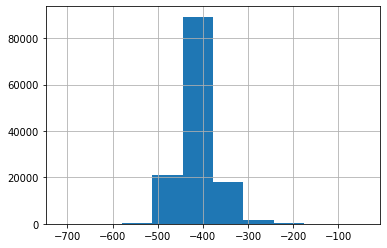

In [61]:
potential_energy_df['potential_energy'].hist()

magnetic_shielding_tensors.csv stores the magnetic shielding tensors **for all atoms in the molecules each molecule**.

It is tensor value, (XX, YX, ZX, XY, YY, ZY, XZ, YZ, ZZ) information is stored for each atom specified by `atom_index`.

In [62]:
magnetic_shielding_tensors_df.head()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3147,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


mulliken_charges.csv stores the mulliken charges for **all atoms in the molecules**.

It is scalar value, one value is stored for each atom specified by `atom_index`.


In [63]:
mulliken_charges_df.head()

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


<AxesSubplot:>

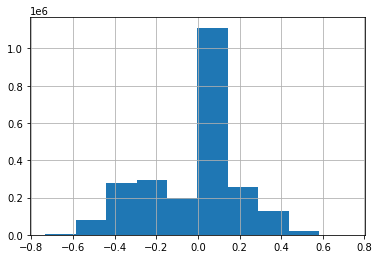

In [64]:
mulliken_charges_df['mulliken_charge'].hist()

scalar_coupling_contributions.csv: 
> The scalar coupling constants in train.csv (or corresponding files) are a sum of four terms. scalar_coupling_contributions.csv contain all these terms.
> the fifth column (fc) is the Fermi Contact contribution, the sixth column (sd) is the Spin-dipolar contribution, the seventh column (pso) is the Paramagnetic spin-orbit contribution and the eighth column (dso) is the Diamagnetic spin-orbit contribution.

As we can see, the first 3 column is the same format with train data, and there are 4 float values `fc`, `sd`, `pso`, and `dso`.
These sum is the actual `scalar_coupling_constant` to predict in this competition.

In [65]:
scalar_coupling_contributions_df.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


So `scalar_coupling_constant` which we need to predict is defined on **atom pair** basis, but many information comes as **each atom** or **molecule** basis.

How to combine these information is the challenge in this competition.

In [66]:
# Atom pair wise info
print('--- Atom pair wise info ---')
print(f'train_df {train_df.shape}')
print(f'test_df {test_df.shape}')
print(f'scalar_coupling_contributions_df {scalar_coupling_contributions_df.shape}')  # only contain train info
print(f'sample_submission_df {sample_submission_df.shape}')  # for test prediction

# Molecule wise info
print('--- Molecule wise info ---')
print(f'potential_energy_df {potential_energy_df.shape}')  # only contain train info
print(f'dipole_moments_df {dipole_moments_df.shape}')  # only contain train info

# Atom wise info
print('--- Atom wise info ---')
print(f'structures_df {structures_df.shape}')  # contains both train/test info
print(f'magnetic_shielding_tensors_df {magnetic_shielding_tensors_df.shape}')  # only contain train info
print(f'mulliken_charges_df {mulliken_charges_df.shape}')  # only contain train info

--- Atom pair wise info ---
train_df (4659076, 6)
test_df (2505190, 5)
scalar_coupling_contributions_df (4659076, 8)
sample_submission_df (2505190, 2)
--- Molecule wise info ---
potential_energy_df (130789, 2)
dipole_moments_df (130789, 4)
--- Atom wise info ---
structures_df (2358875, 6)
magnetic_shielding_tensors_df (2358875, 11)
mulliken_charges_df (2358875, 3)


Number of information is molecule wise < atom wise < atom pair wise

I don't use "additional information" in the following. Let's delete for memory efficiency.

In [67]:
del dipole_moments_df
del magnetic_shielding_tensors_df
del mulliken_charges_df
del potential_energy_df
del scalar_coupling_contributions_df

gc.collect()

84

## Number of atoms

In [68]:
# How many molecules or atoms are there in the dataset?
train_mol_names = train_df['molecule_name'].unique()
test_mol_names = test_df['molecule_name'].unique()

print(f'Number of molecules: train {len(train_mol_names)}, test {len(test_mol_names)}, train+test {len(train_mol_names) + len(test_mol_names)}')
print(f'Number of total atoms: train+test {len(structures_df)}')

Number of molecules: train 85012, test 45777, train+test 130789
Number of total atoms: train+test 2358875


So train/test dataset ratio is around 2:1.

In [69]:
print('name of molecues in train', train_mol_names)
print('name of molecues in test', test_mol_names)

name of molecues in train ['dsgdb9nsd_000001' 'dsgdb9nsd_000002' 'dsgdb9nsd_000003' ...
 'dsgdb9nsd_133882' 'dsgdb9nsd_133883' 'dsgdb9nsd_133884']
name of molecues in test ['dsgdb9nsd_000004' 'dsgdb9nsd_000014' 'dsgdb9nsd_000015' ...
 'dsgdb9nsd_133871' 'dsgdb9nsd_133872' 'dsgdb9nsd_133885']


Molecule name is assigned as increasing order from 000000 until 0133885, and randomly splitted into train and test.

**Atom type**: What kind of atom type are there in the train/test data?

We have only 5 atoms, H, C, N, O and F!

In [70]:
structures_df['atom'].unique()

array(['C', 'H', 'N', 'O', 'F'], dtype=object)

How many number of atoms are there in each molecule?

In [71]:
mol_name_counts = structures_df['molecule_name'].value_counts()
mol_name_counts.head()

dsgdb9nsd_118220    29
dsgdb9nsd_100100    29
dsgdb9nsd_101816    29
dsgdb9nsd_123246    29
dsgdb9nsd_099964    29
Name: molecule_name, dtype: int64

<AxesSubplot:>

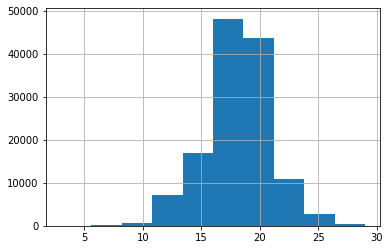

In [72]:
mol_name_counts.hist()

Number of atom in each molecule ranges **3~29**.

Many atoms are actually hydrogen H, how many "heavy atom" (C, N, O and F) are there?

In [73]:
heavy_atoms_in_mol = structures_df[structures_df['atom'] != 'H']['molecule_name'].value_counts()

<AxesSubplot:>

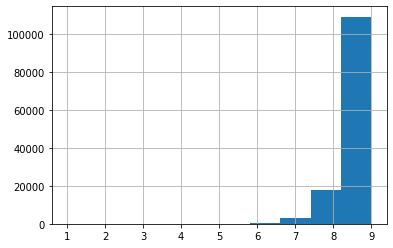

In [74]:
heavy_atoms_in_mol.hist()

Number of heavy atom in each molecule ranges **1~9**. And its histogram is very skewed, as the number of heavy atom increases, number of data increases.

In [75]:
# Histogram of heavy atoms
heavy_atoms_in_mol.value_counts()

9    109012
8     17865
7      3136
6       604
5       125
4        30
3         9
2         5
1         3
Name: molecule_name, dtype: int64

It seems competition data actually comes from **QM9 dataset**!

You can refer QM9 dataset's explanation here.

- http://quantum-machine.org/datasets/

> Computational de novo design of new drugs and materials requires rigorous and unbiased exploration of chemical compound space. However, large uncharted territories persist due to its size scaling combinatorially with molecular size. We report computed geometric, energetic, electronic, and thermodynamic properties for 134k stable small organic molecules made up of CHONF. These molecules correspond to the subset of all 133,885 species with up to nine heavy atoms (CONF) out of the GDB-17 chemical universe of 166 billion organic molecules.

Also, you can download original QM9 dataset from below

 - https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904

So this competition uses QM9 dataset as base molecule list, and calculated `scalar_coupling_constant` which itself is not calculated on original QM9 dataset. QM9 Dataset is actually **enumerated list of organic molecules with up to 9 heavy atoms (CHONF)**. Why the data contains much more 9 heavy atoms than 1 heavy atoms? Because there are much more combination to construct valid molecules when the number of heavy atoms increases!

Also, as you can see below, molecule name is defined in alomost increasing order of heavy atoms.

In [76]:
heavy_atoms_in_mol.sort_index()

dsgdb9nsd_000001    1
dsgdb9nsd_000002    1
dsgdb9nsd_000003    1
dsgdb9nsd_000004    2
dsgdb9nsd_000005    2
                   ..
dsgdb9nsd_133881    9
dsgdb9nsd_133882    9
dsgdb9nsd_133883    9
dsgdb9nsd_133884    9
dsgdb9nsd_133885    9
Name: molecule_name, Length: 130789, dtype: int64

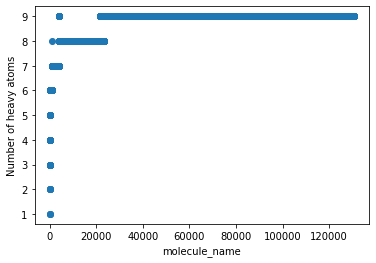

In [77]:
plt.figure()
plt.scatter(np.arange(len(heavy_atoms_in_mol)), heavy_atoms_in_mol.sort_index().values)
plt.xlabel('molecule_name')
plt.ylabel('Number of heavy atoms')
plt.show()
plt.close()

## Molecule visualization

1. Visualize molecules with RDKit (refer [Visualize molecules with RDKit](https://www.kaggle.com/corochann/visualize-molecules-with-rdkit) kernel).

mol_name:  dsgdb9nsd_000001


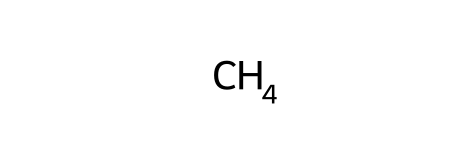

mol_name:  dsgdb9nsd_001000


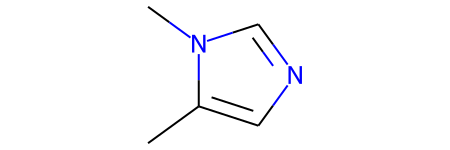

mol_name:  dsgdb9nsd_010000


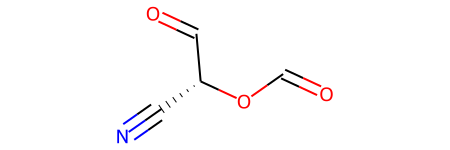

mol_name:  dsgdb9nsd_133885


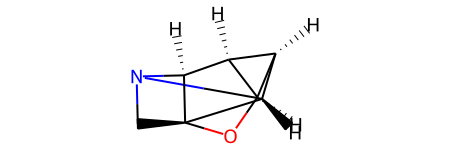

In [78]:
for mol_id in ['000001', '001000', '010000', '133885']:
    mol_name = f'dsgdb9nsd_{mol_id}'
    filepath = input_dir/f'structures/{mol_name}.xyz'
    mol = mol_from_xyz(filepath, to_canonical=True)
    print('mol_name: ', mol_name)
    display(mol)

As we can see, molecule becomes large and more complex structure with increasing order of mol_name.

### Scalar coupling constant

Let's focus on `scalar_coupling_constant`, this competition's label to predict.

As we can see in `train_df` data, scalar coupling constant is defined on atom pair. "coupling type" is defined in each scalar coupling.

In [79]:
coupling_tyes = train_df['type'].unique()
print("coupling_tyes", coupling_tyes)

coupling_tyes ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


It seems we have 8 types of coupling type.

It is the format with number and "J" and some molecule types.

But what is this number 1, 2 or 3?
I refer @geoman3 's answer in [this discussion](https://www.kaggle.com/c/champs-scalar-coupling/discussion/95204#latest-554649).

![](https://i.imgur.com/1jGXP8L.png)

It seems the number indicates to how many bonds separated between these atom pair.
We have number up to 3, meaning that atom pair with too far each other is not in focus of this competition.

Let's see the histogram of `scalar_coupling_constant`.

/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


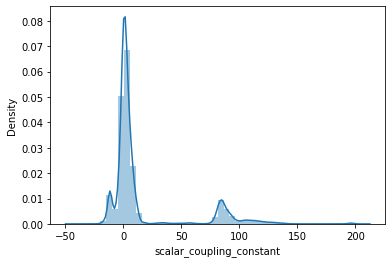

In [80]:
plt.figure()
sns.distplot(train_df['scalar_coupling_constant'])
plt.show()
plt.close()

How about histogram of `scalar_coupling_constant` for each coupling type?

/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

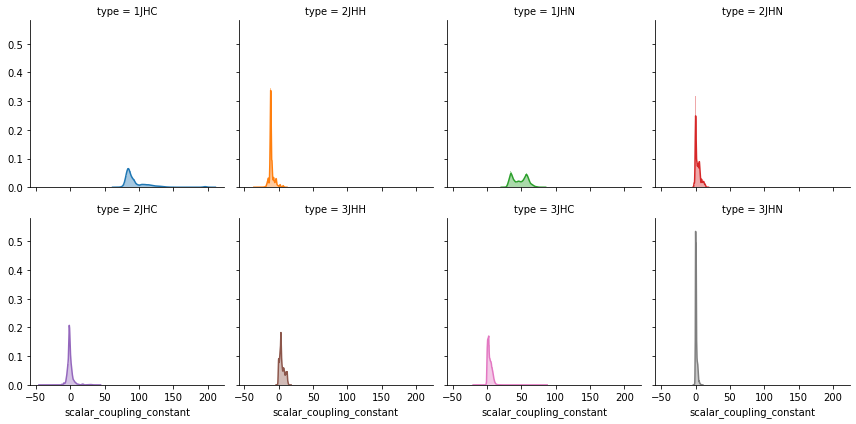

In [81]:
grid = sns.FacetGrid(train_df[['type', 'scalar_coupling_constant']], col='type', hue='type', col_wrap=4)
grid.map(sns.distplot, 'scalar_coupling_constant')

We can see the value ranges very different in each coupling type. "1JHC" coupling type is biggest, around 80. "1JHN" is the second biggest around 50. Other coupling types are around 0.

It may be better to handle each couping type explicitly (include coupling type feature, use different model etc).

# Distance features

Most simple feature we can come up with between atom pair is a distance between these 2 atoms. Let's see how distance related to `scalar_coupling_constant`.

In [82]:
# Calculate distance feature..
# --- dist hist ---

# from https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures_df, how='left',
                  left_on=['molecule_name', f'atom_index_{atom_idx}'],
                  right_on=['molecule_name', 'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train_df = map_atom_info(train_df, 0)
train_df = map_atom_info(train_df, 1)

test_df = map_atom_info(test_df, 0)
test_df = map_atom_info(test_df, 1)

train_p_0 = train_df[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_df[['x_1', 'y_1', 'z_1']].values
test_p_0 = test_df[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_df[['x_1', 'y_1', 'z_1']].values

train_df['dist_speedup'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test_df['dist_speedup'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

In [83]:
# dist_speedup and atom positions are added to both train_df and test_df
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist_speedup
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jipiration/anaconda3/envs/jipiration/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

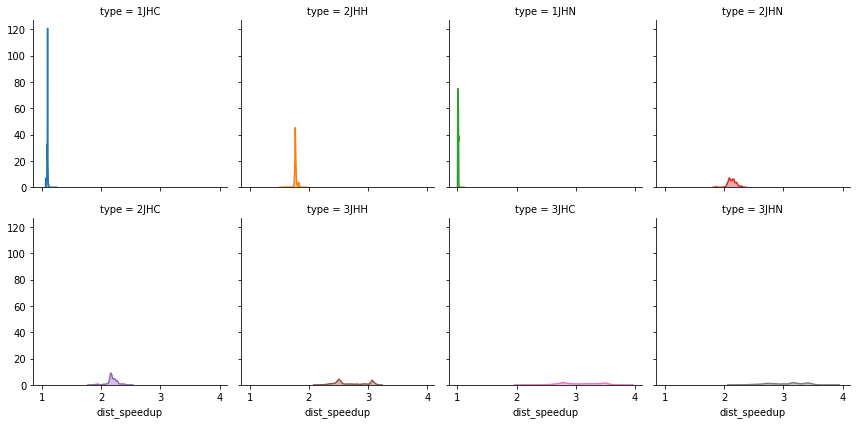

In [85]:
grid = sns.FacetGrid(train_df[['type', 'dist_speedup']], col='type', hue='type', col_wrap=4)
grid.map(sns.distplot, 'dist_speedup')

In [86]:
len(train_df)

4659076

In [87]:
train_df_sampled = train_df.sample(10000)

<AxesSubplot:xlabel='dist_speedup', ylabel='scalar_coupling_constant'>

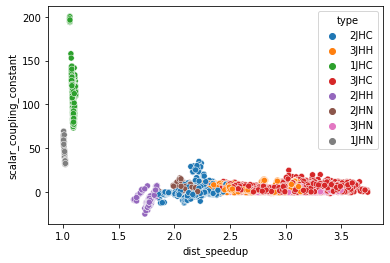

In [88]:
sns.scatterplot(x='dist_speedup', y='scalar_coupling_constant', hue='type', data=train_df_sampled)

Distance for 1J coupling is smaller since atom pair is neighbor to each other, and its scalar coupling constant is higher.

Distance tend to be long from 2J to 3J coupling, but its scalar coupling constant value is similar.

It seems only distance feature is not enough, we need other information to differentiate scalar coupling.

<a id="id4"></a><br>

# Graph Neural Network modeling

Let's use Graph convolutinal neural network for this task. I use [chainer-chemistry](https://github.com/pfnet-research/chainer-chemistry) which provides various kinds of graph convolution network and chemistry related data prerprocessing.

Consider molecule as a "graph" and atom as a "node", we can use graph convolution on molecule.
Benefit of graph convolutional neural network is that it can handle input in node order permutation way.

Here I use WeaveNet implementation, original paper is the following.

 - [Molecular Graph Convolutions: Moving Beyond Fingerprints](https://arxiv.org/abs/1603.00856)
 
 <img src="https://user-images.githubusercontent.com/4609798/59920146-90e3cf00-9464-11e9-9953-c52cce397550.png" width=400px align=center />


Usually most of the graph convolution network deals with bond in molecule as "edge" information of graph, however we need to predict the value on "atom pair" in this competition.

WeaveNet explicitly deals with both atom feature "A" and pair feature "P", so it is easy to use this network for baseline modeling.

### Data preprocessing

In [89]:
train_test_df = pd.concat([train_df, test_df], axis=0, sort=True)
train_test_df['coupling_type_id'] = train_test_df['type'].map(
    {'1JHC': 0, '1JHN': 1, '2JHH': 2, '2JHN': 3, '2JHC': 4, '3JHH': 5, '3JHC': 6, '3JHN': 7})

In [92]:
import chainer

from chainer_chemistry.dataset.preprocessors.common import construct_atomic_number_array
from chainer_chemistry.dataset.preprocessors.weavenet_preprocessor import construct_atom_type_vec, construct_formal_charge_vec, \
    construct_partial_charge_vec, construct_atom_ring_vec, construct_hybridization_vec, construct_hydrogen_bonding, \
    construct_aromaticity_vec, construct_num_hydrogens_vec
from chainer_chemistry.dataset.preprocessors.weavenet_preprocessor import construct_pair_feature
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.links.scaler.standard_scaler import StandardScaler

#### Atom feature

In [94]:
num_max_atoms = 29
atom_list = ['H', 'C', 'N', 'O', 'F']
include_unknown_atom = False

# Each feature can be calculated using fuctions provided by chainer-chemistry using RDKit 'mol' instance
construct_atomic_number_array(mol)
atom_type_vec = construct_atom_type_vec(
    mol, num_max_atoms, atom_list=atom_list,
    include_unknown_atom=include_unknown_atom)
formal_charge_vec = construct_formal_charge_vec(mol, num_max_atoms)
partial_charge_vec = construct_partial_charge_vec(mol, num_max_atoms)
atom_ring_vec = construct_atom_ring_vec(mol, num_max_atoms)
hybridization_vec = construct_hybridization_vec(mol, num_max_atoms)
hydrogen_bonding = construct_hydrogen_bonding(mol, num_max_atoms)
aromaticity_vec = construct_aromaticity_vec(mol, num_max_atoms)

In [96]:
# Each feature is in shape (atom_id, feature_dim), where atom_id is padded to "num_max_atoms" size when atom is not exist.
atom_type_vec.shape, formal_charge_vec.shape, partial_charge_vec.shape, atom_ring_vec.shape, hybridization_vec.shape, hydrogen_bonding.shape, aromaticity_vec.shape

((29, 5), (29, 1), (29, 1), (29, 6), (29, 3), (29, 2), (29, 1))

In [99]:
WEAVE_DEFAULT_NUM_MAX_ATOMS=20

def construct_atom_feature(mol, add_Hs, 
                          num_max_atoms=WEAVE_DEFAULT_NUM_MAX_ATOMS,
                          atom_list=None, include_unknown_atom=False):
    """construct atom feature

    Args:
        mol (Mol): mol instance
        add_Hs (bool): if the `mol` instance was added Hs, set True.
        num_max_atoms (int): number of max atoms
        atom_list (list): list of atoms to extract feature. If None, default
            `ATOM` is used as `atom_list`
        include_unknown_atom (bool): If False, when the `mol` includes atom
            which is not in `atom_list`, it will raise
            `MolFeatureExtractionError`.
            If True, even the atom is not in `atom_list`, `atom_type` is set
            as "unknown" atom.

    Returns (numpy.ndarray): 2 dimensional array. First axis size is
        `num_max_atoms`, representing each atom index.
        Second axis for feature.

    """
    atom_type_vec = construct_atom_type_vec(
        mol, num_max_atoms, atom_list=atom_list,
        include_unknown_atom=include_unknown_atom)
    # TODO: Chilarity
    formal_charge_vec = construct_formal_charge_vec(
        mol, num_max_atoms=num_max_atoms)
    partial_charge_vec = construct_partial_charge_vec(
        mol, num_max_atoms=num_max_atoms)
    atom_ring_vec = construct_atom_ring_vec(
        mol, num_max_atoms=num_max_atoms)
    hybridization_vec = construct_hybridization_vec(
        mol, num_max_atoms=num_max_atoms)
    hydrogen_bonding = construct_hydrogen_bonding(
        mol, num_max_atoms=num_max_atoms)
    aromaticity_vec = construct_aromaticity_vec(
        mol, num_max_atoms=num_max_atoms)
    
    if add_Hs:
        num_hydrogens_vec = construct_num_hydrogens_vec(
            mol, num_max_atoms=num_max_atoms)
        feature = numpy.hstack((atom_type_vec, formal_charge_vec,
                               partial_charge_vec, atom_ring_vec,
                               hybridization_vec, hydrogen_bonding,
                               aromaticity_vec, num_hydrogens_vec))
    else:
        feature = numpy.hstack((atom_type_vec, formal_charge_vec,
                               partial_charge_vec, atom_ring_vec,
                               hybridization_vec, hydrogen_bonding,
                               aromaticity_vec))
    return feature

#### pair feature

In [100]:
pair_feature = construct_pair_feature(mol, num_max_atoms=num_max_atoms)

In [102]:
# Each feature is in shape (atom_id*atom_id, feature_dim).
pair_feature.shape

(841, 7)

In [106]:
from tqdm import tqdm

def to_ndarray(feature_list):
    feat_array = np.empty(len(feature_list), dtype=np.ndarray)
    feat_array[:] = feature_list[:]
    return feat_array

def create_features(mol_names):
    atom_array_list = []
    adj_array_list = []
    to_array_list = []
    from_array_list = []
    label_array_list = []
    coupling_type_id_array_list = []
    
    for mol_name in tqdm(mol_names):
        mol = mol_from_xyz(input_dir/f'structurs/{mol_name}.xyz')
        
        atom_array = construct_atom_feature(mol, add_Hs=True,
                                            num_max_atoms = num_max_atoms, atom_list=atom_list,
                                            include_unknown_atom=False)
        pair_feature = construct_pair_feature(mol, num_max_atoms=num_max_atoms)
#         atom_ids = construct_atomic_number_array(mol)
#         df_mol = structure_df.loc[structure_df['molecule_name'] == mol_name, :]
#         atom_id_array = df_mol['atom_id'].values.astype(np.int32)
#         assert np.alltrue(atom_ids == atom_id_array), print(atom_ids, atom_id_array)

#         xyz_array = df_mol[['x', 'y', 'z']].values
#         dist_array = np.linalg.norm(xyz_array[:, None, :] - xyz_array[None, :, :], axis=2).astype(np.float32)
        
        df_mol2 = train_test_df.loc[train_test_df['molecule_name'] == mol_name, :]
        from_array = df_mol2['atom_index_0'].values.astype(np.int32)
        to_array = df_mol2['atom_index_1'].values.astype(np.int32)
        label_array = df_mol2['scalar_coupling_constant'].values.astype(np.float32)
        #label_array = df_mol2['scalar_coupling_constant_scaled'].values.astype(np.float32)
        coupling_type_id_array = df_mol2['coupling_type_id'].values_astype(np.int32)
        
        atom_array_list.append(atom_array)
        adj_array_list.append(pair_feature)
        from_array_list.append(from_array)
        to_array_list.append(to_array)
        coupling_type_id_array_list.append(coupling_type_id_array)
        label_array_list.append(label_array)
    return tuple(map(to_ndarray, [atom_array_list, adj_array_list, from_array_list, to_arrat_list, coupling_type_id_array_list, label_array_list]))

In [ ]:
# For debugging

k = create_features(train_mol_names[:2])

Calculating all features takes time (around half day), so I already uploaded calculated data as "dataset" [here](https://www.kaggle.com/corochann/champs-weave-dataset). We can use this cache for now.

In [110]:
def load_dataset(filepath):
    if not os.path.exists(filepath):
        return None
    load_data = numpy.load(filepath, allow_pickle=True)
    result = []
    i = 0
    while True:
        key = 'arr_{}'.format(i)
        if key in load_data.keys():
            result.append(load_data[key])
            i += 1
        else:
            break
    return NumpyTupleDataset(*result)

with timer('train'):
    train = load_dataset('./input/champs-weave-dataset/train_data_v2.npz')
with timer('test'):
    train = load_dataset('./input/champs-weave-dataset/test_data_v2.npz')

[train] done in 15.193 s
[test] done in 8.919 s


Let me explain each data.

`train[0]` is to get 0-th molecule's data.

In [111]:
atom_array, dist_array, from_array, to_array, coupling_type_id_array, label_array = train[0]

- atom_array: stores feature for each atom, shape (num_atom, feature_dim)
- dist_array: stores feature for each atom pair, shape (num_atom * num_atom, feature_dim)

- from_array: stores index for atom pair to be predicted
- to_array  : stores index for atom pair to be predicted
- coupling_type_id_array: stores coupling type for each atom pair to be predicted
- label_array: stores `scalar_couling_constant` for each atom pair to be predicted

In [113]:
atom_array.shape, dist_array.shape

((29, 20), (841, 8))

In [114]:
from_array, to_array, label_array, coupling_type_id_array

(array([2, 2, 2, 3, 3], dtype=int32),
 array([0, 1, 3, 0, 1], dtype=int32),
 array([nan, nan, nan, nan, nan], dtype=float32),
 array([4, 0, 5, 0, 4], dtype=int32))

### converter

Each data (`train[0], train[1]...`) have different length for the label.
`converter` defines how to make batch from data for neural network training.

In [ ]:
from chainer.dataset.convert import _concat_arrays, to_device
from itertools import chain

def concat_with_padding(batch, device, i, padding):
    return to_device(device, _concat_arrays([example[i] for example in batch], padding))


def flatten_array(list_of_list, dtype=np.float32):
    flatten_list = list(chain.from_iterable(list_of_list))
    return np.array(flatten_list, dtype=dtype)

class EdgeConverter:

    def __init__(self, return_label=True):
        self.return_label = return_label

    def __call__(self, batch, device=None):
        # atom_array, dist_array, from_array, to_array, coupling_type_id_array, label_array, 
        atom = concat_with_padding(batch, device, 0, padding=None)
        adj = concat_with_padding(batch, device, 1, padding=None)
        from_array = to_device(device, flatten_array([example[2] for example in batch], dtype=np.int32))
        to_array = to_device(device,flatten_array([example[3] for example in batch], dtype=np.int32))
        coupling_type = to_device(device, flatten_array([example[4] for example in batch], dtype=np.int32))
        label = to_device(device, flatten_array([example[5] for example in batch], dtype=np.float32))
        batch_indices = to_device(device, flatten_array([np.ones(len(example[2]), dtype=np.int32) * i for i, example in enumerate(batch)], dtype=np.int32))

        if self.return_label:
            return atom, adj, from_array, to_array, coupling_type, batch_indices, label[:, None]
        else:
            return atom, adj, from_array, to_array, coupling_type, batch_indices


In [ ]:
converter = EdgeConverter()
#print('0', train[0])
#print('1', train[1])
batch = [train[0], train[1]]

input_data = converter(batch, device=-1)
atom, adj, from_array, to_array, coupling_type, batch_indices, label = input_data
print('input_data:', atom.shape, adj.shape, from_array.shape, to_array.shape, coupling_type.shape, batch_indices.shape, label.shape)

`train[0]` and `train[1]` are stacked to create 1-minibatch in the above example.

### Scaler

Each coupling constant value is different, so I will define scaler for each coupling constant.

In [ ]:
class CouplingTypeScaler(chainer.Link):
    
    def __init__(self):
        super(CouplingTypeScaler, self).__init__()
        self.mean = None
        self.register_presistent('mean')
        self.std = None
        self.register_persistent('std')
        
        
    def set_param(self, mean, std):
        self.mean = mean
        self.std = std
        
    def inverse_transform(self, x, coupling_indices):
        assert x.ndim == 2, x.shape
        assert x.shape[1] == 1, x.shape
        assert x.shape[0] == len(coupling_indices)
        x = x * self.std[coupling_indices][:, None] + self.mean[coupling_indices][:, None]
        return x

In [ ]:
# scale each scalar couplint constant
scaler = StandardScaler()

mean_list = []
std_list = []

types =  ['1JHC', '1JHN',  '2JHH', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']

for target_type in types:
    print('scaling type: ', target_type)
    label = train_df.loc[train_df['type'] == target_type, 'scalar_coupling_constant'].values
    train_df.loc[train_df['type'] == target_type, 'scalar_coupling_constant_scaled'] = scaler.fit_transform(label)
    print('mean', scaler.mean[0], 'std', scaler.std[0])
    mean_list.append(scaler.mean[0])
    std_list.append(scaler.std[0])

coupling_type_scaler = CouplingTypeScaler()
coupling_type_scaler.set_param(np.array(mean_list, dtype=np.float32), np.array(std_list, dtype=np.float32))


## Model definition